In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import pickle
import optuna

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

c:\Users\user\miniconda3\envs\ds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загрузим и объединим обучающую и тестовую выборки для предобработки. У нас нет признаков, которые считаются, задействуя весь датафрейм, поэтому такое объединение не вызовет утечки данных. Но это позволит корректно создать лаговые признаки для тестовой выборки

## Предобработка и feature engineering

In [ ]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')
df = pd.concat([train_df, test_df])[['date', 'time', 'target', 'temp_pred', 'weather_pred', 'temp']]
df['date'] = pd.to_datetime(df['date']).dt.normalize()

#get test dates for future model fitting
start_test = test_df['date'].min()
end_test = test_df['date'].max()

df.head()

,date,time,target,temp_pred,weather_pred,temp
0,2019-01-01,0,481.510,2.0,"пасм, ветер",2.9
1,2019-01-01,1,462.872,2.0,"пасм, ветер",2.9
2,2019-01-01,2,449.718,2.0,"пасм, ветер",2.9
3,2019-01-01,3,430.908,2.0,"пасм, ветер",4.3
4,2019-01-01,4,415.163,2.0,"пасм, ветер",4.3


Добавим в полученный датафрейм отобранные нами признаки. Функции, перечисленные ниже добавляют только те признаки, которые оказались полезными, т.е. улучшали метрику в ходе наших экспериментов

In [ ]:
def add_calendar_features(df):
    """
    Функция извлекает из даты и добавляет в датафрейм календарные фичи: день (число),
    день недели, номер недели, месяц, год
    """
    df['date'] = pd.to_datetime(df['date']).dt.normalize()
    df['dow'] = df['date'].dt.dayofweek
    df['day'] = df['date'].dt.day
    df['week'] = df['date'].dt.isocalendar().week.astype('int32')
    df['month'] = df['date'].dt.month

    #OHE code month
    months = {1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun',
            7: 'jul', 8: 'aug', 9: 'sep', 10: 'oct', 11: 'nov', 12: 'dec'}
    for month in months:
        df[months[month]] = np.where((df['month'] == month), 1, 0)

    return df

In [ ]:
def add_lags(df):
    """
    Функция добавляет избранные лаги для целевой переменной и температуры
    """
    #add target lags
    for i in [24, 24*2, 24*3, 24*4, 24*5, 24*6, 24*7, 25, 26, 47, 49, 71, 73]:
        df[f'target_lag_{i}'] = df['target'].shift(i)

    #add yesterdays target and temperature statistics
    for feature in ['target', 'temp']:
        daily = df.groupby('date', as_index=False)[feature].agg(daily_mean='mean', daily_median='median', daily_max='max', daily_min='min')
        for stat in ['mean', 'median', 'max', 'min']:
            daily[f'yesterday_{stat}_{feature}'] = daily[f'daily_{stat}'].shift(1)
        df = df.merge(daily[['date', f'yesterday_mean_{feature}', f'yesterday_median_{feature}', f'yesterday_max_{feature}', f'yesterday_min_{feature}']], how='left', on='date')
        df[f'yesterday_diff_{feature}'] = df[f'yesterday_max_{feature}'] - df[f'yesterday_min_{feature}']

    #delete nans where there's no lag data (start of period)
    df['na_sum'] = df.isna().sum(axis=1)
    df = df[df['na_sum'] == 0]
    df = df.drop('na_sum', axis=1)

    #drop actual temperature as it causes dataleaks
    df = df.drop('temp', axis=1)

    return df

In [ ]:
def add_weather_and_daylight(df):
    """
    Функция обрабатывает данные о природном освещении и погоде, создавая в итоге бинарный
    признак, помечающий часы, когда должно быть светло, потому что солнце над горизонтом,
    но темно из-за погодных условий. Мы используем прогнозную погоду во избежание утечек
    """
    #create columns for certain bad weather types
    bad_weathers = {'пасм': 'overcast', 'дожд': 'rain', 'снег': 'snow',
                    'ливень': 'heavy_rain', 'гроз': 'thunder', 'шторм': 'storm'}
    for weather_type in bad_weathers:
        df[bad_weathers[weather_type]] = np.where(df['weather_pred'].str.contains(weather_type), 1, 0)

    #process cloudy separately so that not to include 'малообл'
    df['cloudy'] = np.where((df['weather_pred'].str.contains(' обл')) |
                            (df['weather_pred'].str.startswith('обл')), 1, 0)

    #read and preprocess our table with sunset and sunrise times for each day
    daylight = pd.read_csv('light_day.csv')
    daylight = daylight.rename(columns={'Дата': 'date', 'Восход': 'sunrise', 'Заход': 'sunset'})
    daylight = daylight[['date', 'sunrise', 'sunset']]
    daylight['date'] = pd.to_datetime(daylight['date']).dt.normalize()
    daylight['day'] = daylight['date'].dt.day
    daylight['month'] = daylight['date'].dt.month
    daylight['sunrise'] = daylight['sunrise'].str.replace(':', '.').str.lstrip('0').astype('float')
    daylight['sunset'] = daylight['sunset'].str.replace(':', '.').str.lstrip('0').astype('float')
    daylight = daylight[['day', 'month', 'sunrise', 'sunset']]

    #merge sunset and sunrise data to original df
    df_with_daylight = df.merge(daylight, on=['month', 'day'], how='left')

    #mark light hours, i.e. those between sunrise and sunset
    df_with_daylight['light'] = np.where(df_with_daylight['time'].between(df_with_daylight['sunrise'],
                                                                    df_with_daylight['sunset']), 1, 0)

    #mark hours that should be light but are dark because of bad weather conditions
    df_with_daylight['dark_weather'] = np.where((df_with_daylight['light'] == 1) &
                                  (df_with_daylight[['rain', 'heavy_rain', 'thunder',
                                                  'storm', 'snow', 'overcast', 'cloudy']].any(axis='columns') == 1), 1, 0)

    #drop interim features that didn't prove useful
    #(we don't drop overcast, rain, snow and light as the model uses them as features)
    df_with_daylight = df_with_daylight.drop(['weather_pred', 'sunrise', 'sunset', 'cloudy', 'heavy_rain',
                                              'thunder', 'storm'], axis=1)

    return df_with_daylight

In [ ]:
def add_daysoff(df):
    """
    Функция загружает файлы производственных календарей, обрабатывает их и проставляет
    метку 1 для всех выходных и праздничных дней. Эта категория шире суббот и воскресений
    (что мы ранее извлекли из даты), т.к. включает дополнительно государственные праздники
    и нерабочие дни, объявленные указами президента
    Кроме того, функция создает столбец "рабочий час", отмечая единицами часы, являющиеся
    рабочими по производственному календарю с учетом коротких дней перед праздниками
    """
    #read and preprocess tables with Russian production calendars
    c19 = pd.read_csv('calendar2019.csv')
    c20 = pd.read_csv('calendar2020.csv')
    c21 = pd.read_csv('calendar2021.csv')
    c22 = pd.read_csv('calendar2022.csv')
    c23 = pd.read_csv('calendar2023.csv')

    def get_daysoff(df, year):
        """
        Функция принимает датафрейм производственного календаря и возвращает список
        всех выходных дней в соответствующем году
        """
        months = {'Январь': '01', 'Февраль': '02', 'Март': '03', 'Апрель': '04', 'Май': '05', 'Июнь': '06',
        'Июль': '07', 'Август': '08', 'Сентябрь': '09', 'Октябрь': '10', 'Ноябрь': '11', 'Декабрь': '12'}

        yearly_daysoff = []
        yearly_short = []
        for month in months:
            #filter out days with *. these are working short days before a holiday
            daysoff = [day for day in df[month].item().split(',') if '*' not in day]
            daysoff = [day if len(day) > 1 else '0'+day for day in daysoff]

            #make a separate list of short working days (prior to a holiday)
            short_days = [day for day in df[month].item().split(',') if '*' in day]
            short_days = [day if len(day) > 1 else '0'+day for day in short_days]

            #format as proper dates
            daysoff = [(year + '-' + months[month] + '-' + day) for day in daysoff]
            yearly_daysoff.extend(daysoff)
            short_days = [(year + '-' + months[month] + '-' + day) for day in short_days]
            yearly_short.extend(short_days)

        return yearly_daysoff, yearly_short

    #get days off for all 5 years
    all_daysoff = []
    all_short = []
    years = {'2019': c19, '2020': c20, '2021': c21, '2022': c22, '2023': c23}
    for year in years:
        all_daysoff.extend(get_daysoff(df=years[year], year=year)[0])
        all_short.extend(get_daysoff(df=years[year], year=year)[1])

    #add daysoff and short feature to original df
    df['dayoff'] = np.where(df['date'].astype('str').isin(all_daysoff), 1, 0)
    df['working_short'] = np.where(df['date'].astype('str').isin(all_short), 1, 0)

    #mark working hours
    df['working_hour'] = np.where(((df['dayoff'] == 0) & (df['working_short'] == 0) & (df['time'].isin(list(range(9, 18))))) |
                                  ((df['dayoff'] == 0) & (df['working_short'] == 1) & (df['time'].isin(list(range(9, 17))))), 1, 0)

    df = df.drop('working_short', axis=1)

    return df

In [ ]:
def add_sin_cos_time(df):
    """
    Функция заменяет оригинальное время (по 24-часовой шкале) его циклической
    категоризацией. Это нужно для того, чтобы расстояние между 23 и 0 часов не было
    больше, чем для любой другой пары соседних часов
    """
    def cos_sin_categorise(data, cos_column_name, sin_column_name, column_to_categorise):
        """
        Применяет cos-sin тригонометрическую категоризацию
        :param data: DataFrame содержащий данные
        :param cos_column_name: Название будущей колонки с cos
        :param sin_column_name: Название будущей колонки с sin
        :param column_to_categorise: Назване колонки, которое хотим категоризовать
        """
        data[cos_column_name] = np.cos((2*np.pi *data[column_to_categorise])/data[column_to_categorise].nunique())
        data[sin_column_name] = np.sin((2*np.pi *data[column_to_categorise])/data[column_to_categorise].nunique())

    cos_sin_categorise(data=df, cos_column_name='cos_time', sin_column_name='sin_time', column_to_categorise='time')
    return df

In [ ]:
def add_school_vacations(df):
    """
    Функция отмечает единицами дни школьных каникул и нулями - все остальные дни
    """
    vacs = pd.read_csv('holidays.csv')
    vacs = vacs.rename(columns={'Дата': 'date', 'Каникулы': 'school_vac'})
    vacs['date'] = pd.to_datetime(vacs['date']).dt.normalize()
    df = df.merge(vacs, on='date', how='left')
    return df

Добавим все созданные нами признаки в датафрейм

In [ ]:
df = add_calendar_features(df)
df = add_lags(df)
df = add_weather_and_daylight(df)
df = add_daysoff(df)
df = add_sin_cos_time(df)
df = add_school_vacations(df)
print(df.shape)
df.head()

(39872, 53)


,date,time,target,temp_pred,dow,day,week,month,jan,feb,...,overcast,rain,snow,light,dark_weather,dayoff,working_hour,cos_time,sin_time,school_vac
0,2019-01-08,0,517.676,-1.0,1,8,2,1,1,0,...,1,0,0,0,0,1,0,1.000000,0.000000,1
1,2019-01-08,1,485.831,-1.0,1,8,2,1,1,0,...,1,0,0,0,0,1,0,0.965926,0.258819,1
2,2019-01-08,2,461.959,-1.0,1,8,2,1,1,0,...,1,0,0,0,0,1,0,0.866025,0.500000,1
3,2019-01-08,3,449.592,-1.0,1,8,2,1,1,0,...,1,0,0,0,0,1,0,0.707107,0.707107,1
4,2019-01-08,4,440.941,-1.0,1,8,2,1,1,0,...,1,0,0,0,0,1,0,0.500000,0.866025,1


## Первый этап: обучение линейной модели

На первом этапе мы обучаем линейную регрессию с регуляризацией. Мы остановили свой выбор на таком типе алгоритмов машинного обучения, поскольку линейные модели, в отличие от деревянных, хороши в экстраполировании найденных зависимостей. Кроме того, выбранная нами лассо-регрессия - хороший выбор для анализа важности признаков, т.к. используемая ей l1 регуляризация зануляет вес незначимых признаков.

In [ ]:
def evaluate(y_true, y_pred, model_name):
    """
    Функция рассчитывает и выводит метрики модели
    :param y_true: вектор истинных значений целевой переменной
    :param y_pred: вектор предсказаний модели
    :model_name: имя модели (для вывода)
    """
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    #print metrics...
    metrics = {'MAE': mae, 'MAPE': mape, 'r2': r2}
    for metric in metrics:
        print(f"{model_name} {metric}: {metrics[metric]}")

    #... and return them
    return mae, mape, r2

In [ ]:
def linear_cross_val(cols_to_take, df=df):
    """
    Функция кросс-валидации для LightGBM регрессора
    :param cols_to_take: столбцы, которые модель использует в качестве признаков
    :param df: датафрейм, который необходимо разделить на обучающую и тестовую выборки
    """
    maes = []
    mapes = []
    r2 = []

    #separate test from train and valid. it's always the same and corresponds to test_dataset.csv
    crossval_set = df[df['date'] < test_df['date'].min()]

    #use time series split to split train and valid. valid size is about 6 months (3 for valid and 3 for test)
    tscv = TimeSeriesSplit(test_size=91*24)

    for i, (train_index, test_index) in enumerate(tscv.split(crossval_set)):
        print(f"Fold {i+1}:")
        train = crossval_set[crossval_set.index.isin(train_index)]
        test = crossval_set[crossval_set.index.isin(test_index)]

        end_train = train['date'].max()
        start_test = test['date'].min()
        end_test = test['date'].max()
        test_dates = test['date']

        print(f"End of train: {end_train.date()}")
        print(f"Test: from {start_test.date()} to {end_test.date()}")

        X_train = train[cols_to_take]
        y_train = train['target']
        X_test = test[cols_to_take]
        y_test = test['target']

        pipe = make_pipeline(StandardScaler(), Lasso(alpha=0.275))
        pipe.fit(X_train, y_train)

        #predict for test
        preds = pipe.predict(X_test)
        preds = pd.DataFrame({'y_pred': preds, 'date': test_dates, 'y_true': y_test})

        #evaluete model
        metrics = evaluate(preds['y_true'], preds['y_pred'], 'LGBM')
        maes.append(metrics[0])
        mapes.append(metrics[1])
        r2.append(metrics[2])

        #plot test fact and forecast
        plot_df = pd.DataFrame({'date': preds['date'].head(14*24), 'y_true': preds['y_true'].head(14*24), 'y_pred': preds['y_pred'].head(14*24)})
        fig, ax = plt.subplots(figsize=(12, 3))
        g = sns.lineplot(data=plot_df)
        plt.title(f'CV step {i+1}')
        plt.show()

    #return model from last fold. it is fit on maximum train dataset
    return(maes, mapes, r2, pipe)

Fold 1:
End of train: 2021-12-28
Test: from 2021-12-28 to 2022-03-30


LGBM MAE: 13.030015934260984
LGBM MAPE: 0.023074826089341922
LGBM r2: 0.9362161221823092


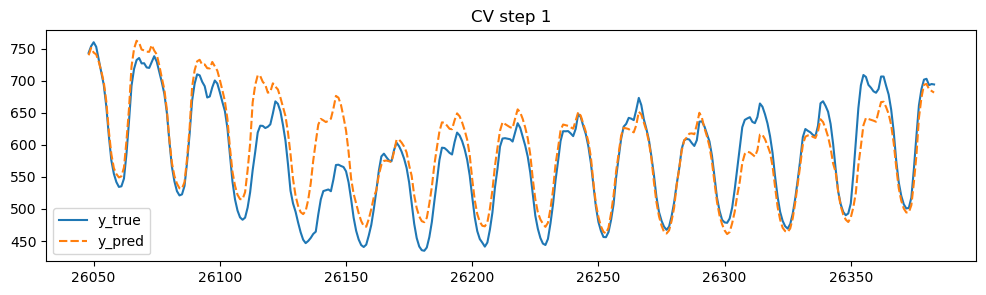

Fold 2:
End of train: 2022-03-30
Test: from 2022-03-30 to 2022-06-29
LGBM MAE: 11.180966293825069
LGBM MAPE: 0.024992213268876226
LGBM r2: 0.9628014473743315


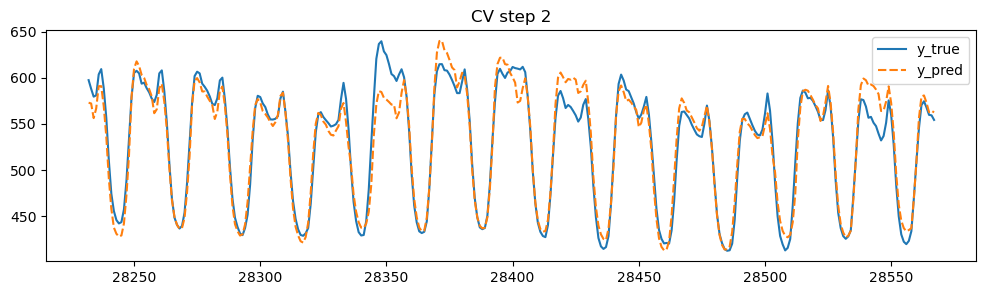

Fold 3:
End of train: 2022-06-29
Test: from 2022-06-29 to 2022-09-29
LGBM MAE: 9.84998235324975
LGBM MAPE: 0.02396063215288889
LGBM r2: 0.9653363574448101


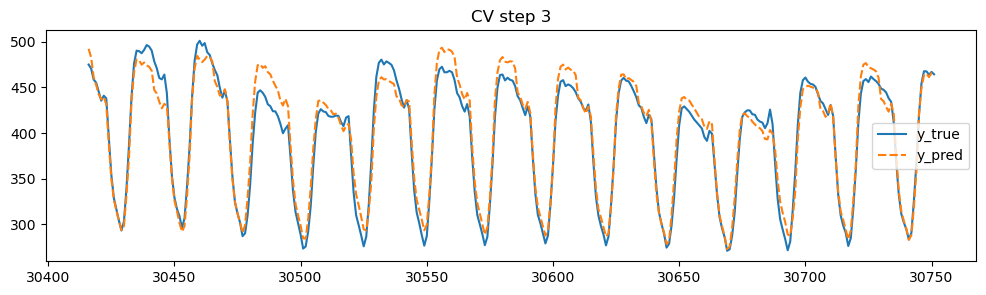

Fold 4:
End of train: 2022-09-29
Test: from 2022-09-29 to 2022-12-30
LGBM MAE: 12.080918825239637
LGBM MAPE: 0.02211955264231427
LGBM r2: 0.9727934268659872


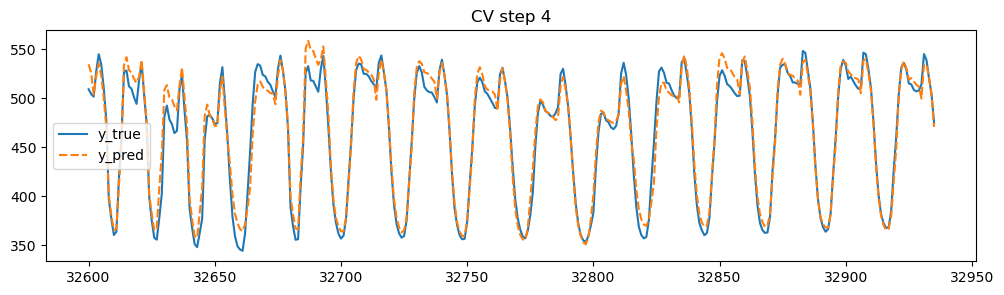

Fold 5:
End of train: 2022-12-30
Test: from 2022-12-31 to 2023-03-31
LGBM MAE: 12.832127745732356
LGBM MAPE: 0.023882283476551816
LGBM r2: 0.9275118616084549


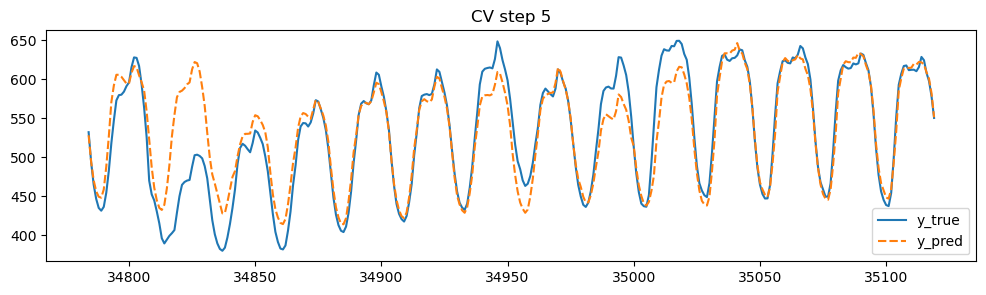

In [ ]:
lin_maes, lin_mapes, lin_r2, lin_model = linear_cross_val(df=df, cols_to_take=['target_lag_24', 'target_lag_96', 'target_lag_120', 'target_lag_144',
                                                                               'target_lag_168', 'temp_pred', 'dow', 'day', 'week', 'jan', 'feb', 'mar',
                                                                               'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'cos_time',
                                                                               'working_hour', 'dark_weather', 'yesterday_diff_temp'])

## Оценка модели первого этапа

Посмотрим на средние метрики по итогам кросс-валидации

In [ ]:
metrics = {'MAE': lin_maes, 'MAPE': lin_mapes, 'r2': lin_r2}
for metric in metrics:
    print(f"Linreg mean {metric}: {np.mean(metrics[metric])}")

Linreg mean MAE: 11.79480223046156
Linreg mean MAPE: 0.023605901525994625
Linreg mean r2: 0.9529318430951786


И на тесте

In [ ]:
test = df[df['date'] >= test_df['date'].min()]
X_test = test[['target_lag_24', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'temp_pred', 'dow', 'day', 'week', 'jan', 'feb', 'mar', 'apr', 'may', 'jun',
       'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'cos_time', 'working_hour', 'dark_weather', 'yesterday_diff_temp']]
y_test = test['target']

preds = lin_model.predict(X_test)
preds = pd.DataFrame({'y_pred': preds, 'date': test['date'], 'y_true': test['target']})
metrics = evaluate(preds['y_true'], preds['y_pred'], 'LGBM on train')

LGBM on train MAE: 9.988168175643608
LGBM on train MAPE: 0.024007800046597055
LGBM on train r2: 0.9672431318349087


Однако при всех вышеперечисленных преимуществах линейные модели не отличаются высокой точностью

Для сравнения ниже мы рассчитали метрики для константной модели, предсказывающей потребление, равное потреблению ровно сутки назад

In [ ]:
metrics = evaluate(test['target'], test['target_lag_24'], 'Constant model')

Constant model MAE: 12.110993801652892
Constant model MAPE: 0.02833135663293302
Constant model r2: 0.9423153330397813


Ошибка линейных моделей велика и относительно стабильна на обучающей и тестовой выборке. Обучим выбранную модель на всей обучающей выборке и сделаем предсказание для всех наблюдений, включая тестовую выборку. Также рассчитаем ошибку модели как разность истинной целевой переменной и предсказаний лассо

In [ ]:
train = df[df['date'] < test_df['date'].min()]
X_train = train[['target_lag_24', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'temp_pred', 'dow', 'day', 'week', 'jan', 'feb', 'mar', 'apr', 'may', 'jun',
       'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'cos_time', 'working_hour', 'dark_weather', 'yesterday_diff_temp']]
y_train = train['target']

model_stage1 = make_pipeline(StandardScaler(), Lasso(alpha=0.275))
model_stage1.fit(X_train, y_train)

df['pred_stage1'] = model_stage1.predict(df[['target_lag_24', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'temp_pred', 'dow', 'day', 'week', 'jan', 'feb', 'mar', 'apr', 'may', 'jun',
       'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'cos_time', 'working_hour', 'dark_weather', 'yesterday_diff_temp']])
df['stage1_error'] = df['target'] - df['pred_stage1']


## Второй этап: бустинг на ошибках

На втором этапе постараемся повысить точность нашей модели. Для этого градиентным бустингом предскажем ошибку первой модели и сложим оценки двух моделей для получения финального прогноза. Метрики точности в этом разделе ма рассчитываем не для промежуточных оценок, а для финального прогноза.

In [ ]:
def plotImp(model, X, num = 40, fig_size = (15, 5)):
    """
    Функция отрисовывает график важности признаков модели в порядке убывания
    """
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features importance')
    plt.tight_layout()
    plt.show()

In [ ]:
def lgbm_cross_val(cols_to_take, cat_features=[], df=df):
    """
    Функция кросс-валидации для LightGBM регрессора
    :param cols_to_take: столбцы, которые модель использует в качестве признаков
    :param cat_features: категориальные признаки. Сейчас их нет, но функция оставляет такую
                         возможность
    :param df: датафрейм, который необходимо разделить на обучающую и тестовую выборки
    """
    maes = []
    mapes = []
    r2 = []

    #separate test from train and valid. it's always the same and corresponds to test_dataset.csv
    crossval_set = df[df['date'] < test_df['date'].min()]

    #use time series split to split train and valid. valid size is about 6 months (3 for valid and 3 for test)
    tscv = TimeSeriesSplit(test_size=91*24)

    for i, (train_index, test_index) in enumerate(tscv.split(crossval_set)):
        print(f"Fold {i+1}:")
        train_and_valid = crossval_set[crossval_set.index.isin(train_index)]
        test = crossval_set[crossval_set.index.isin(test_index)]
        train = train_and_valid.iloc[:-(91*24), :]
        valid = train_and_valid.iloc[-(91*24):, :]

        end_train = train['date'].max()
        start_valid = valid['date'].min()
        end_valid = valid['date'].max()
        start_test = test['date'].min()
        end_test = test['date'].max()
        test_dates = test['date']

        print(f"End of train: {end_train.date()}")
        print(f"Valid: from {start_valid.date()} to {end_valid.date()}")
        print(f"Test: from {start_test.date()} to {end_test.date()}")

        X_train = train[cols_to_take]
        y_train = train['stage1_error']
        X_valid = valid[cols_to_take]
        y_valid = valid['stage1_error']
        X_test = test[cols_to_take]
        y_test = test['stage1_error']

        eval_set = [(X_valid, y_valid)]

        cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

        for col in cat_features:
            X_train[col] = pd.Categorical(X_train[col])
            X_valid[col] = pd.Categorical(X_valid[col])
            X_test[col] = pd.Categorical(X_test[col])

        lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26, objective='mse')
        lgbm_reg.fit(
                X_train,
                y_train,
                categorical_feature=cat_idx,
                eval_set=eval_set,
                early_stopping_rounds=200,
                verbose=100
            )

        #predict for test
        pred_errors = lgbm_reg.predict(X_test)
        preds = pd.DataFrame({'error_predicted': pred_errors, 'date': test_dates, 'y_true': test['target'], 'stage1_predict': test['pred_stage1']})
        preds['y_pred'] = preds['stage1_predict'] + preds['error_predicted']

        #evaluete model
        metrics = evaluate(preds['y_true'], preds['y_pred'], 'LGBM')
        maes.append(metrics[0])
        mapes.append(metrics[1])
        r2.append(metrics[2])

        #plot test fact and forecast
        plot_df = pd.DataFrame({'date': preds['date'].head(14*24), 'y_true': preds['y_true'].head(14*24), 'y_pred': preds['y_pred'].head(14*24)})
        fig, ax = plt.subplots(figsize=(12, 3))
        g = sns.lineplot(data=plot_df)
        plt.title(f'CV step {i+1}')
        plt.show()


    plotImp(lgbm_reg, X_train)

    #return model from last fold. it is fit on maximum train dataset
    return(maes, mapes, r2, preds, lgbm_reg)

Fold 1:
End of train: 2021-09-28
Valid: from 2021-09-28 to 2021-12-28
Test: from 2021-12-28 to 2022-03-30


[100]	valid_0's l2: 125.011
[200]	valid_0's l2: 127.901
LGBM MAE: 10.392637870278758
LGBM MAPE: 0.018084470330526483
LGBM r2: 0.9634135946809302


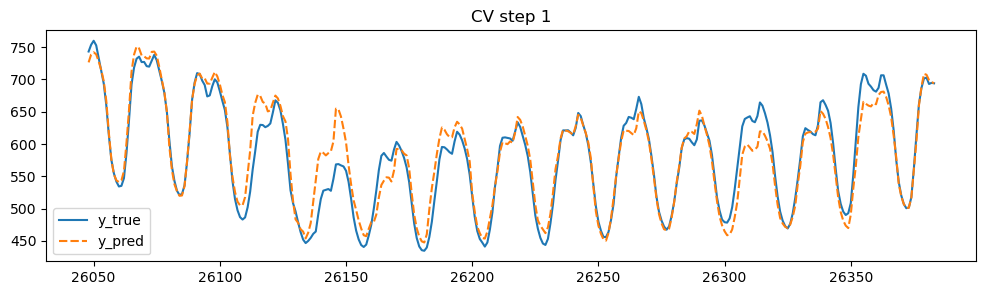

Fold 2:
End of train: 2021-12-28
Valid: from 2021-12-28 to 2022-03-30
Test: from 2022-03-30 to 2022-06-29
[100]	valid_0's l2: 199.706
[200]	valid_0's l2: 195.844
[300]	valid_0's l2: 193.749
[400]	valid_0's l2: 192.946
[500]	valid_0's l2: 192.727
[600]	valid_0's l2: 191.024
[700]	valid_0's l2: 190.168
[800]	valid_0's l2: 190.695
LGBM MAE: 8.117970984333596
LGBM MAPE: 0.017804762509485435
LGBM r2: 0.9778610592258535


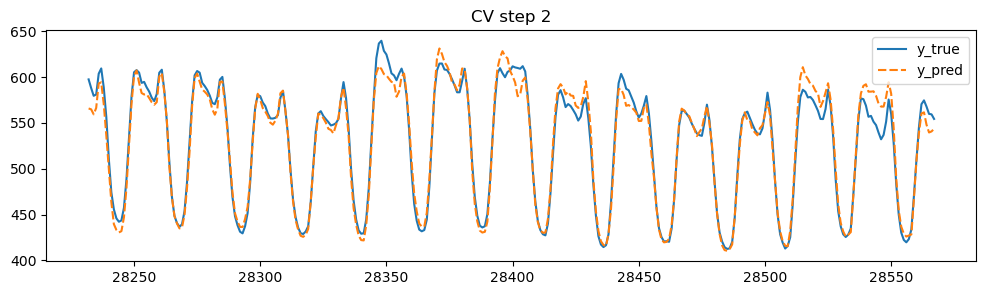

Fold 3:
End of train: 2022-03-30
Valid: from 2022-03-30 to 2022-06-29
Test: from 2022-06-29 to 2022-09-29
[100]	valid_0's l2: 132.058
[200]	valid_0's l2: 126.979
[300]	valid_0's l2: 125.347
[400]	valid_0's l2: 125.256
[500]	valid_0's l2: 125.852
LGBM MAE: 6.4508390370793185
LGBM MAPE: 0.015376063060187779
LGBM r2: 0.9841757782773018


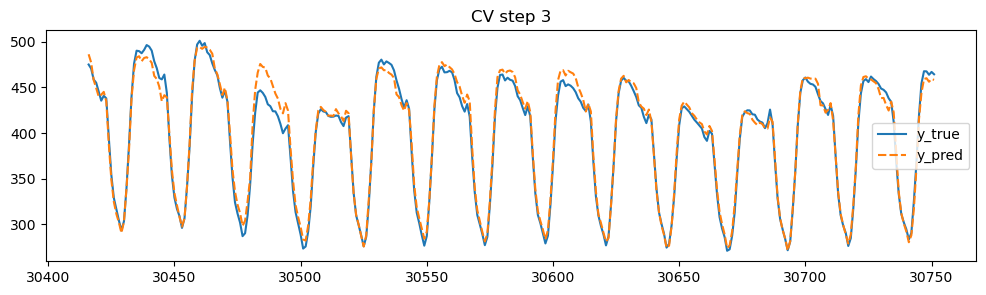

Fold 4:
End of train: 2022-06-29
Valid: from 2022-06-29 to 2022-09-29
Test: from 2022-09-29 to 2022-12-30
[100]	valid_0's l2: 74.0925
[200]	valid_0's l2: 72.5085
[300]	valid_0's l2: 71.0053
[400]	valid_0's l2: 70.8703
[500]	valid_0's l2: 71.4474
LGBM MAE: 8.30669040202427
LGBM MAPE: 0.015141215348392936
LGBM r2: 0.9864309403609266


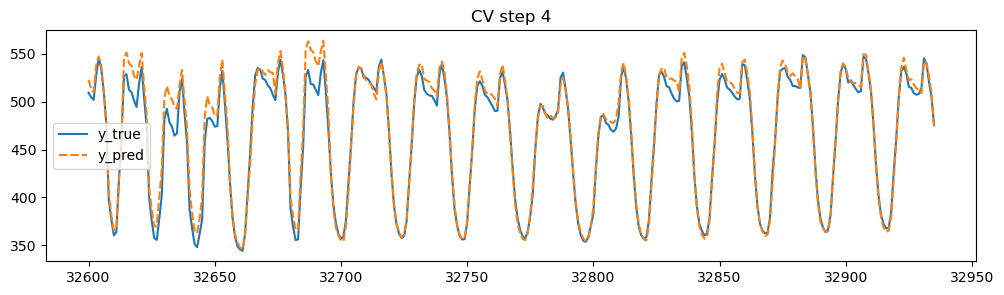

Fold 5:
End of train: 2022-09-29
Valid: from 2022-09-29 to 2022-12-30
Test: from 2022-12-31 to 2023-03-31
[100]	valid_0's l2: 116.253
[200]	valid_0's l2: 119.085
LGBM MAE: 9.392665725054345
LGBM MAPE: 0.017060290875051103
LGBM r2: 0.9666290865652293


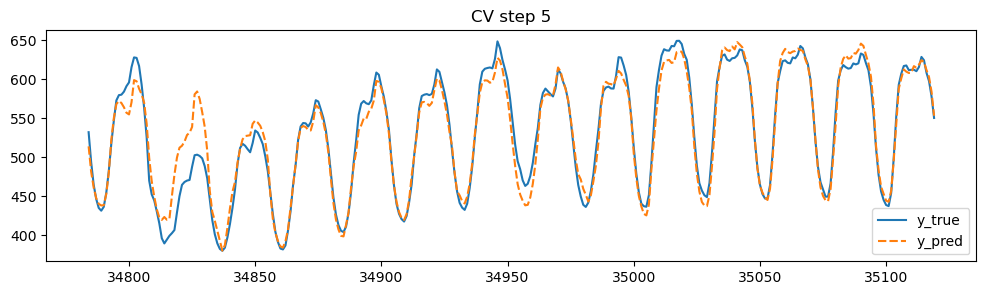

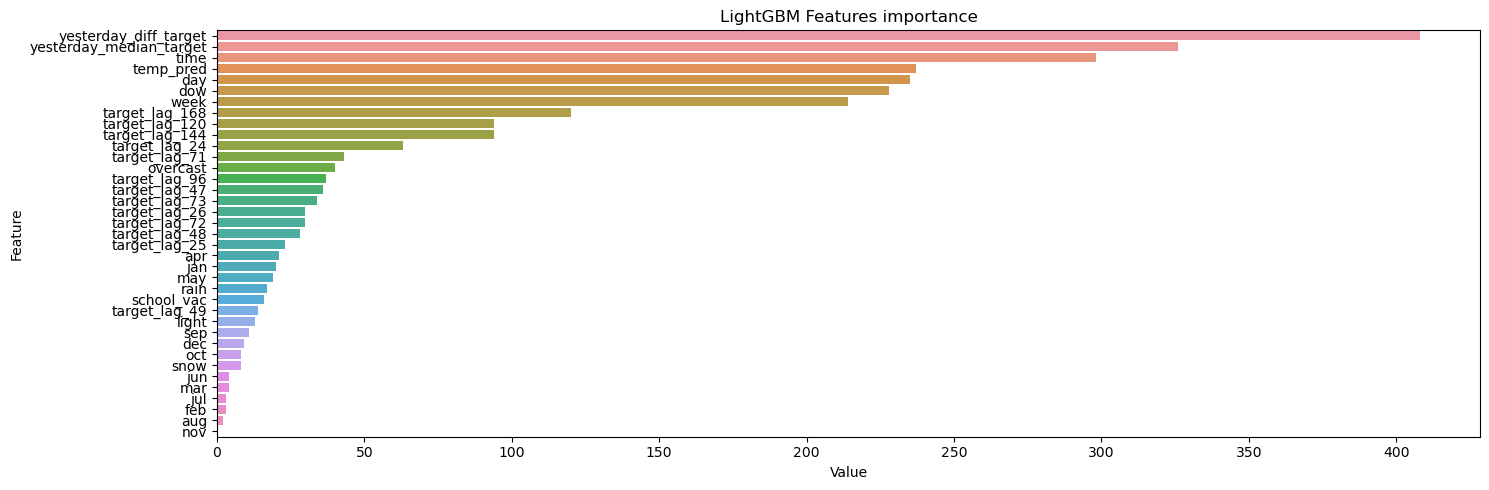

In [ ]:
lgbm_maes, lgbm_mapes, lgbm_r2, lgbm_forecast, lgbm_model = lgbm_cross_val(df=df, cols_to_take=['target_lag_24','target_lag_48', 'target_lag_72',
                                                                                                'target_lag_96', 'target_lag_120', 'target_lag_144',
                                                                                                'target_lag_168', 'target_lag_25', 'target_lag_26',
                                                                                                'target_lag_47', 'target_lag_49', 'target_lag_71',
                                                                                                'target_lag_73', 'temp_pred', 'dow', 'day', 'week',
                                                                                                'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug',
                                                                                                'sep', 'oct', 'nov', 'dec', 'time', 'yesterday_median_target',
                                                                                                'yesterday_diff_target', 'overcast', 'rain', 'snow', 'light',
                                                                                                'school_vac'])

## Оценка модели второго этапа

На кросс-валидации:

In [ ]:
metrics = {'MAE': lgbm_maes, 'MAPE': lgbm_mapes, 'r2': lgbm_r2}
for metric in metrics:
    print(f"LGBM mean {metric}: {np.mean(metrics[metric])}")

LGBM mean MAE: 8.532160803754056
LGBM mean MAPE: 0.01669336042472875
LGBM mean r2: 0.9757020918220481


И на тесте:

In [ ]:
test = df[df['date'] >= test_df['date'].min()]
X_test = test[['target_lag_24', 'target_lag_48', 'target_lag_72', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'target_lag_25',
'target_lag_26', 'target_lag_47', 'target_lag_49', 'target_lag_71', 'target_lag_73', 'temp_pred', 'dow', 'day', 'week', 'jan', 'feb', 'mar', 'apr', 'may',
'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'time', 'yesterday_median_target', 'yesterday_diff_target', 'overcast', 'rain', 'snow', 'light',
'school_vac']]

pred_errors = lgbm_model.predict(X_test)
preds = pd.DataFrame({'error_predicted': pred_errors, 'date': test['date'], 'y_true': test['target'], 'stage1_predict': test['pred_stage1']})
preds['y_pred'] = preds['stage1_predict'] + preds['error_predicted']
metrics = evaluate(preds['y_true'], preds['y_pred'], 'LGBM on train')

LGBM on train MAE: 7.536316449967296
LGBM on train MAPE: 0.01777159190905571
LGBM on train r2: 0.9790230416636045


Используем Optuna для тюнинга гиперпараметров. Это позволит еще немного повысить точность

In [ ]:
def objective(trial, df=df, cols_to_take=['target_lag_24', 'target_lag_48', 'target_lag_72', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'target_lag_25',
'target_lag_26', 'target_lag_47', 'target_lag_49', 'target_lag_71', 'target_lag_73', 'temp_pred', 'dow', 'day', 'week', 'jan', 'feb', 'mar', 'apr', 'may',
'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'time', 'yesterday_median_target', 'yesterday_diff_target', 'overcast', 'rain', 'snow', 'light', 'school_vac'], cat_features=[], h=3):

    crossval_set = df[df['date'] < test_df['date'].min()]

    train = crossval_set.iloc[:-(91*24), :]
    valid = crossval_set.iloc[-(91*24):, :]

    X_train = train[cols_to_take]
    y_train = train['stage1_error']
    X_valid = valid[cols_to_take]
    y_valid = valid['stage1_error']

    eval_set = [(X_valid, y_valid)]

    cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

    for col in cat_features:
        X_train[col] = pd.Categorical(X_train[col])
        X_valid[col] = pd.Categorical(X_valid[col])

    param = {
        'metric': 'mse',
        'random_state': 26,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }
    model = lgbm.LGBMRegressor(**param)

    model.fit(X_train,y_train,categorical_feature=cat_idx,eval_set=eval_set,early_stopping_rounds=100,verbose=500)

    preds = model.predict(X_valid)

    trial.set_user_attr(key="best_booster", value=model)

    return mean_absolute_error(y_valid, preds)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction='minimize'
    )
    study.optimize(objective, n_trials=10, callbacks=[callback])
    best_model=study.user_attrs["best_booster"]

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-11-04 18:07:05,585] A new study created in memory with name: no-name-d34da4b7-ed40-49a1-a0fb-59dc701057bd


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[500]	valid_0's l2: 220.256
[1000]	valid_0's l2: 193.432
[1500]	valid_0's l2: 186.6
[2000]	valid_0's l2: 182.801
[2500]	valid_0's l2: 181.547


[I 2023-11-04 18:08:27,057] Trial 0 finished with value: 9.082175577411297 and parameters: {'reg_alpha': 0.025248177307282887, 'reg_lambda': 0.04654682858793193, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 677, 'min_child_samples': 101, 'feature_fraction': 0.5}. Best is trial 0 with value: 9.082175577411297.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[500]	valid_0's l2: 242.018
[1000]	valid_0's l2: 209.788
[1500]	valid_0's l2: 195.797
[2000]	valid_0's l2: 189.256
[2500]	valid_0's l2: 184.952
[3000]	valid_0's l2: 182.327
[3500]	valid_0's l2: 180.614
[4000]	valid_0's l2: 179.39
[4500]	valid_0's l2: 178.206
[5000]	valid_0's l2: 177.553


[I 2023-11-04 18:10:33,236] Trial 1 finished with value: 9.228680836270481 and parameters: {'reg_alpha': 2.2358941231596408, 'reg_lambda': 0.3190289622241655, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 140, 'min_child_samples': 222, 'feature_fraction': 0.4}. Best is trial 0 with value: 9.082175577411297.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.5
[500]	valid_0's l2: 198.139
[1000]	valid_0's l2: 185.163
[1500]	valid_0's l2: 182.434


[I 2023-11-04 18:11:27,969] Trial 2 finished with value: 9.358708281300215 and parameters: {'reg_alpha': 0.12720824466173064, 'reg_lambda': 1.2219442968846448, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 800, 'min_child_samples': 148, 'feature_fraction': 0.5}. Best is trial 0 with value: 9.082175577411297.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[500]	valid_0's l2: 259.769
[1000]	valid_0's l2: 224.957
[1500]	valid_0's l2: 207.974
[2000]	valid_0's l2: 199.481
[2500]	valid_0's l2: 194.374
[3000]	valid_0's l2: 191.032
[3500]	valid_0's l2: 188.607
[4000]	valid_0's l2: 187.078


[I 2023-11-04 18:13:13,424] Trial 3 finished with value: 9.252167250178312 and parameters: {'reg_alpha': 0.004162172720960458, 'reg_lambda': 0.11240805768247296, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 586, 'min_child_samples': 104, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 9.082175577411297.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l2: 165.144
[1000]	valid_0's l2: 163.234


[I 2023-11-04 18:14:26,954] Trial 4 finished with value: 8.74051903495088 and parameters: {'reg_alpha': 0.005058056013977945, 'reg_lambda': 0.21530920714959906, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 687, 'min_child_samples': 28, 'feature_fraction': 0.8}. Best is trial 4 with value: 8.74051903495088.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.30000000000000004
[500]	valid_0's l2: 211.653
[1000]	valid_0's l2: 193.332
[1500]	valid_0's l2: 186.769
[2000]	valid_0's l2: 183.714


[I 2023-11-04 18:15:24,540] Trial 5 finished with value: 9.411336033592304 and parameters: {'reg_alpha': 1.5935038418601963, 'reg_lambda': 0.0020340504506713973, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 804, 'min_child_samples': 264, 'feature_fraction': 0.30000000000000004}. Best is trial 4 with value: 8.74051903495088.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.2
[500]	valid_0's l2: 246.801
[1000]	valid_0's l2: 221.443
[1500]	valid_0's l2: 211.05
[2000]	valid_0's l2: 204.81
[2500]	valid_0's l2: 202.237
[3000]	valid_0's l2: 199.95


[I 2023-11-04 18:16:32,560] Trial 6 finished with value: 9.718870137208164 and parameters: {'reg_alpha': 0.01277605192814341, 'reg_lambda': 0.004346965728654717, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 268, 'min_child_samples': 287, 'feature_fraction': 0.2}. Best is trial 4 with value: 8.74051903495088.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.5
[500]	valid_0's l2: 206.102
[1000]	valid_0's l2: 186.775
[1500]	valid_0's l2: 179.637
[2000]	valid_0's l2: 177.431
[2500]	valid_0's l2: 175.506


[I 2023-11-04 18:17:21,804] Trial 7 finished with value: 9.271573286074968 and parameters: {'reg_alpha': 0.004291233930226905, 'reg_lambda': 0.0341045250606166, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 877, 'min_child_samples': 216, 'feature_fraction': 0.5}. Best is trial 4 with value: 8.74051903495088.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.30000000000000004
[500]	valid_0's l2: 201.828
[1000]	valid_0's l2: 187.733
[1500]	valid_0's l2: 185.346


[I 2023-11-04 18:19:09,226] Trial 8 finished with value: 9.353311558957733 and parameters: {'reg_alpha': 0.0035435137447894817, 'reg_lambda': 0.0073974165918504016, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 869, 'min_child_samples': 114, 'feature_fraction': 0.30000000000000004}. Best is trial 4 with value: 8.74051903495088.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.5
[500]	valid_0's l2: 219.153
[1000]	valid_0's l2: 197.014
[1500]	valid_0's l2: 188.903
[2000]	valid_0's l2: 185.326
[2500]	valid_0's l2: 182.907
[3000]	valid_0's l2: 180.87
[3500]	valid_0's l2: 179.358
[4000]	valid_0's l2: 178.274
[4500]	valid_0's l2: 177.428
[5000]	valid_0's l2: 176.974


[I 2023-11-04 18:22:17,784] Trial 9 finished with value: 9.357827624517876 and parameters: {'reg_alpha': 0.018467117210444584, 'reg_lambda': 0.6402323656446468, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 790, 'min_child_samples': 249, 'feature_fraction': 0.5}. Best is trial 4 with value: 8.74051903495088.


Number of finished trials: 10
Best trial: {'reg_alpha': 0.005058056013977945, 'reg_lambda': 0.21530920714959906, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 687, 'min_child_samples': 28, 'feature_fraction': 0.8}


In [ ]:
study.optimize(objective, n_trials=10, callbacks=[callback])
best_model=study.user_attrs["best_booster"]

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l2: 176.972


[I 2023-11-04 18:24:49,822] Trial 10 finished with value: 9.056578957042296 and parameters: {'reg_alpha': 0.0015873850736070863, 'reg_lambda': 7.255852022573395, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 436, 'min_child_samples': 2, 'feature_fraction': 0.9}. Best is trial 4 with value: 8.74051903495088.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l2: 179.393
[1000]	valid_0's l2: 177.797


[I 2023-11-04 18:26:24,487] Trial 11 finished with value: 9.086428351226772 and parameters: {'reg_alpha': 0.002828512612942157, 'reg_lambda': 6.500036966033125, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 388, 'min_child_samples': 1, 'feature_fraction': 0.9}. Best is trial 4 with value: 8.74051903495088.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l2: 169.721


[I 2023-11-04 18:27:25,616] Trial 12 finished with value: 9.026090475679489 and parameters: {'reg_alpha': 0.0010755624487681248, 'reg_lambda': 9.205300014076586, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 486, 'min_child_samples': 23, 'feature_fraction': 0.9}. Best is trial 4 with value: 8.74051903495088.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7
[500]	valid_0's l2: 167.968
[1000]	valid_0's l2: 165.008
[1500]	valid_0's l2: 164.232


[I 2023-11-04 18:28:41,442] Trial 13 finished with value: 8.86070086185737 and parameters: {'reg_alpha': 0.001070666806891011, 'reg_lambda': 1.5297770498599415, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 584, 'min_child_samples': 42, 'feature_fraction': 0.7}. Best is trial 4 with value: 8.74051903495088.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7
[500]	valid_0's l2: 200.374
[1000]	valid_0's l2: 169.184
[1500]	valid_0's l2: 165.131
[2000]	valid_0's l2: 164.063
[2500]	valid_0's l2: 163.17
[3000]	valid_0's l2: 162.496


[I 2023-11-04 18:30:56,760] Trial 14 finished with value: 8.849764122837461 and parameters: {'reg_alpha': 0.0011832394688527851, 'reg_lambda': 1.5626763110073563, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 649, 'min_child_samples': 53, 'feature_fraction': 0.7}. Best is trial 4 with value: 8.74051903495088.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[500]	valid_0's l2: 210.24
[1000]	valid_0's l2: 180.238
[1500]	valid_0's l2: 174.975
[2000]	valid_0's l2: 171.599
[2500]	valid_0's l2: 170.317
[3000]	valid_0's l2: 169.593


[I 2023-11-04 18:31:49,597] Trial 15 finished with value: 8.885630669161714 and parameters: {'reg_alpha': 0.10713708765702441, 'reg_lambda': 0.20434193009921517, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 686, 'min_child_samples': 58, 'feature_fraction': 0.7}. Best is trial 4 with value: 8.74051903495088.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7
[500]	valid_0's l2: 203.88
[1000]	valid_0's l2: 170.39
[1500]	valid_0's l2: 165.352
[2000]	valid_0's l2: 163.738
[2500]	valid_0's l2: 162.85
[3000]	valid_0's l2: 162.346


[I 2023-11-04 18:33:35,904] Trial 16 finished with value: 8.829895194560734 and parameters: {'reg_alpha': 0.007987584729323226, 'reg_lambda': 2.0248519960055322, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 988, 'min_child_samples': 67, 'feature_fraction': 0.7}. Best is trial 4 with value: 8.74051903495088.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l2: 188.862
[1000]	valid_0's l2: 176.182
[1500]	valid_0's l2: 172.222
[2000]	valid_0's l2: 171.026


[I 2023-11-04 18:34:15,578] Trial 17 finished with value: 8.900558080694045 and parameters: {'reg_alpha': 0.04176913589949836, 'reg_lambda': 0.2925462798239591, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 943, 'min_child_samples': 83, 'feature_fraction': 0.8}. Best is trial 4 with value: 8.74051903495088.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l2: 190.165
[1000]	valid_0's l2: 178.884
[1500]	valid_0's l2: 172.777
[2000]	valid_0's l2: 170.879
[2500]	valid_0's l2: 170.28


[I 2023-11-04 18:35:11,025] Trial 18 finished with value: 9.089233677614558 and parameters: {'reg_alpha': 0.01041989981364991, 'reg_lambda': 3.405337548754184, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 997, 'min_child_samples': 153, 'feature_fraction': 0.8}. Best is trial 4 with value: 8.74051903495088.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.6000000000000001
[500]	valid_0's l2: 227.086
[1000]	valid_0's l2: 195.257
[1500]	valid_0's l2: 185.282
[2000]	valid_0's l2: 181.356
[2500]	valid_0's l2: 179.081
[3000]	valid_0's l2: 176.911
[3500]	valid_0's l2: 175.089
[4000]	valid_0's l2: 174.279


[I 2023-11-04 18:37:37,907] Trial 19 finished with value: 9.11954609792494 and parameters: {'reg_alpha': 0.00796124440468403, 'reg_lambda': 2.9444205887247583, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 268, 'min_child_samples': 144, 'feature_fraction': 0.6000000000000001}. Best is trial 4 with value: 8.74051903495088.


Оценим результат на тесте:

In [ ]:
X_test = test[['target_lag_24', 'target_lag_48', 'target_lag_72', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'target_lag_25',
'target_lag_26', 'target_lag_47', 'target_lag_49', 'target_lag_71', 'target_lag_73', 'temp_pred', 'dow', 'day', 'week', 'jan', 'feb', 'mar', 'apr', 'may',
'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'time', 'yesterday_median_target', 'yesterday_diff_target', 'overcast', 'rain', 'snow', 'light', 'school_vac']]

pred_errors = best_model.predict(X_test)
preds = pd.DataFrame({'error_predicted': pred_errors, 'date': test['date'], 'y_true': test['target'], 'stage1_predict': test['pred_stage1']})
preds['y_pred'] = preds['stage1_predict'] + preds['error_predicted']
metrics = evaluate(preds['y_true'], preds['y_pred'], 'LGBM after Optuna')

LGBM after Optuna MAE: 7.084712972893452
LGBM after Optuna MAPE: 0.01663447790990105
LGBM after Optuna r2: 0.9811216969447724


## Сохранение моделей

Сохраним модель для дальнейшего использования

In [ ]:
# save the models to pickle files
lin_pkl = "model1.pkl"
lgbm_pkl = "model2.pkl"

with open(lin_pkl, 'wb') as file:
    pickle.dump(lin_model, file)

with open(lgbm_pkl, 'wb') as file:
    pickle.dump(best_model, file)

Убедимся, что качество модели, загруженной из файла, не отличается

In [ ]:
# load models from pickle files
with open(lin_pkl, 'rb') as file:
    lin_reg_loaded = pickle.load(file)
with open(lgbm_pkl, 'rb') as file:
    lgbm_reg_loaded = pickle.load(file)

In [ ]:
df['pred_stage1'] = lin_reg_loaded.predict(df[['target_lag_24', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'temp_pred', 'dow', 'day', 'week', 'jan', 'feb', 'mar', 'apr', 'may', 'jun',
       'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'cos_time', 'working_hour', 'dark_weather', 'yesterday_diff_temp']])
df['stage1_error'] = df['target'] - df['pred_stage1']

X_test = test[['target_lag_24', 'target_lag_48', 'target_lag_72', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'target_lag_25',
'target_lag_26', 'target_lag_47', 'target_lag_49', 'target_lag_71', 'target_lag_73', 'temp_pred', 'dow', 'day', 'week', 'jan', 'feb', 'mar', 'apr', 'may',
'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'time', 'yesterday_median_target', 'yesterday_diff_target', 'overcast', 'rain', 'snow', 'light', 'school_vac']]

pred_errors = lgbm_reg_loaded.predict(X_test)
preds = pd.DataFrame({'error_predicted': pred_errors, 'date': test['date'], 'y_true': test['target'], 'stage1_predict': test['pred_stage1']})
preds['y_pred'] = preds['stage1_predict'] + preds['error_predicted']
metrics = evaluate(preds['y_true'], preds['y_pred'], 'Saved models')

Saved models MAE: 7.084712972893452
Saved models MAPE: 0.01663447790990105
Saved models r2: 0.9811216969447724


Все верно, результат совпадает с финальным после оптимизации гиперпараметров